In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import io
import os
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from bioinfokit.visuz import cluster
import dataframe_image as dfi

############################################
############### Parsing dati ###############

#Lettura dati da dataset
path = str(pathlib.Path().absolute())
path_high_lev = path + "/prova1_high_level.csv"
path_low_lev = path + "/prova1_low_level.txt"


df_high = pd.read_csv(path_high_lev)
df_low = pd.read_csv(path_low_lev, skiprows=[0,2,3], delimiter=r"\s+")

df_low = df_low.drop(df_low.tail(8).index)

# PCA LOW LEVEL

In [2]:
df_low
dfi.export(df_low,"df_low.png", max_rows=10)

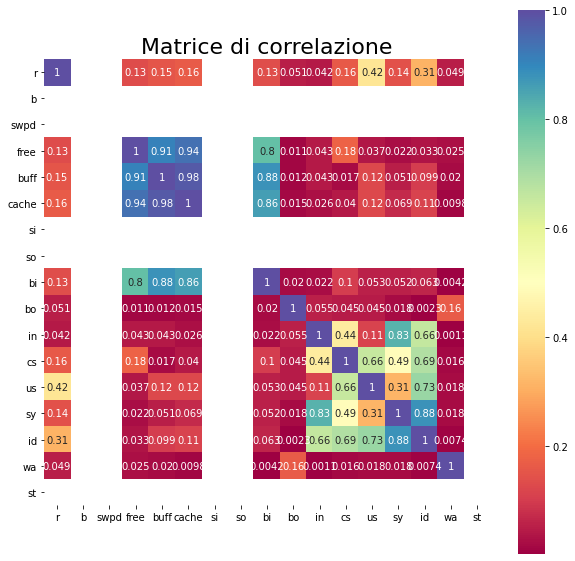

In [3]:
corrMatrix = df_low.corr()
plt.figure(figsize = (10, 10))
plt.title('Matrice di correlazione', size=22)
sn.heatmap(abs(corrMatrix), annot=True, cmap='Spectral', square=True)
plt.show();

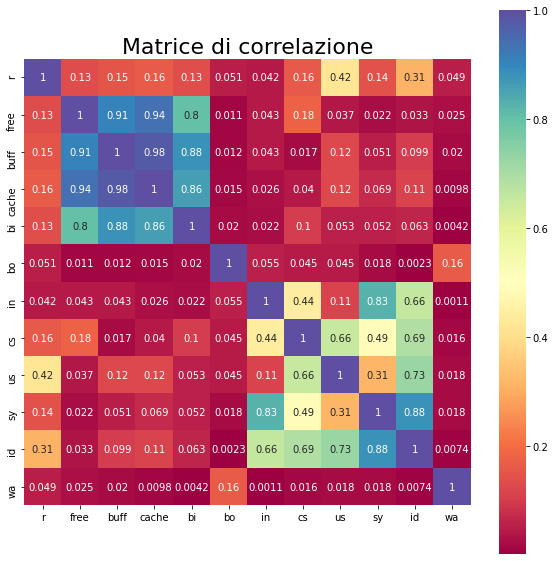

In [4]:
df_low.drop(columns=['b', 'swpd', 'si', 'so', 'st'], inplace=True)

corrMatrix = df_low.corr()
plt.figure(figsize = (10, 10))
plt.title('Matrice di correlazione', size=22)
sn.heatmap(abs(corrMatrix), annot=True, cmap='Spectral', square=True)
plt.show();

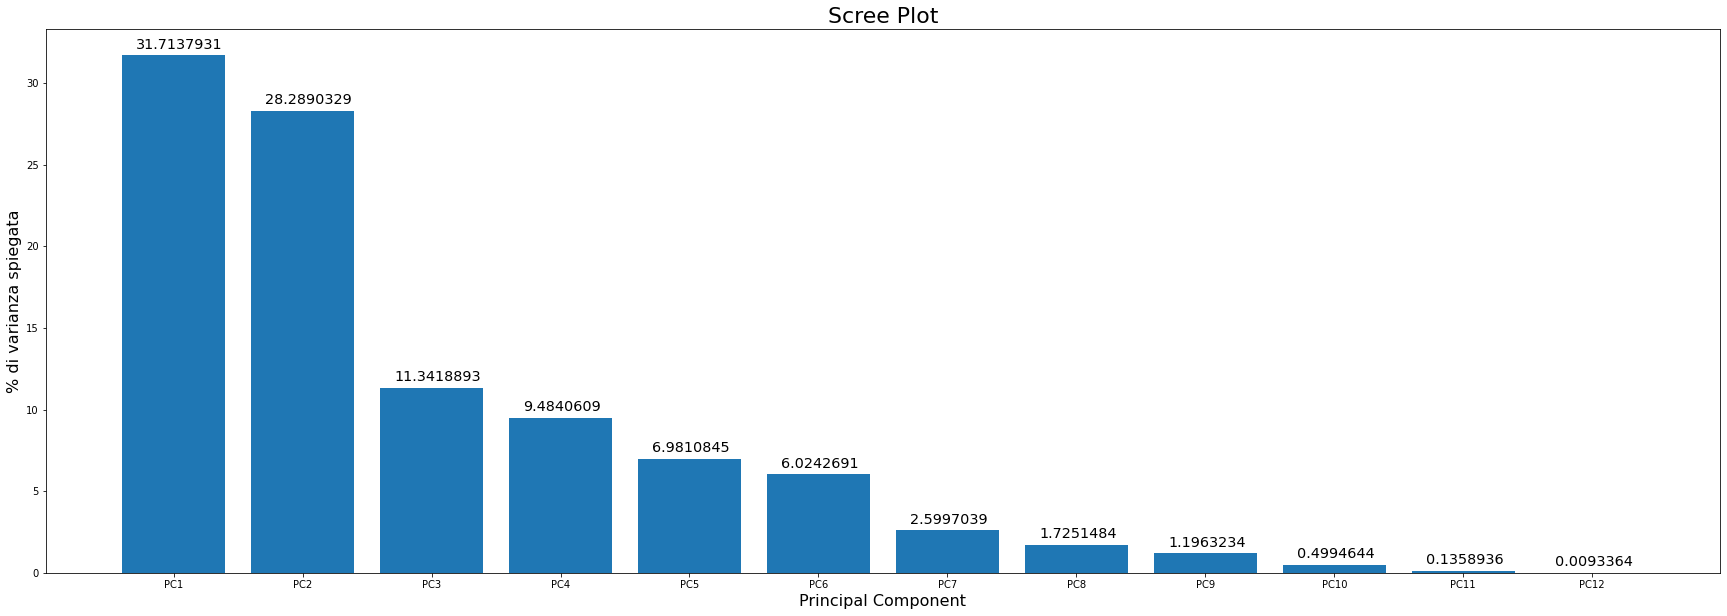

In [5]:
# Normalizzazione Z-score
x = StandardScaler().fit_transform(df_low)
scaled_df = pd.DataFrame(x)


##############################################
################# PCA ########################

pca = PCA() #modello
pca.fit(scaled_df) #aggiunta dataset
pca_data = pca.transform(scaled_df) #creazione 

#Calcolo percentuali di varianza spiegata per ogni PCi
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=7)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

# Definizione PCA dataframe
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.figure(figsize = (30, 10))
plt.ylabel('% di varianza spiegata', size=16)
plt.xlabel('Principal Component', size=16)
plt.title('Scree Plot', size=22)
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels, align='center')
# Annotazione percentuali
i = 1; j = 0.4
for i in range(len(per_var)):
    plt.annotate('{:.7f}'.format(per_var[i]), (i+0.71, per_var[i] + j), fontsize="x-large")
plt.show()

#Autovalori
eigenvalues = pca.explained_variance_

In [6]:
t=0
for i in range(0,7):
    t=per_var[i]+t
    
print(t)

96.4338337


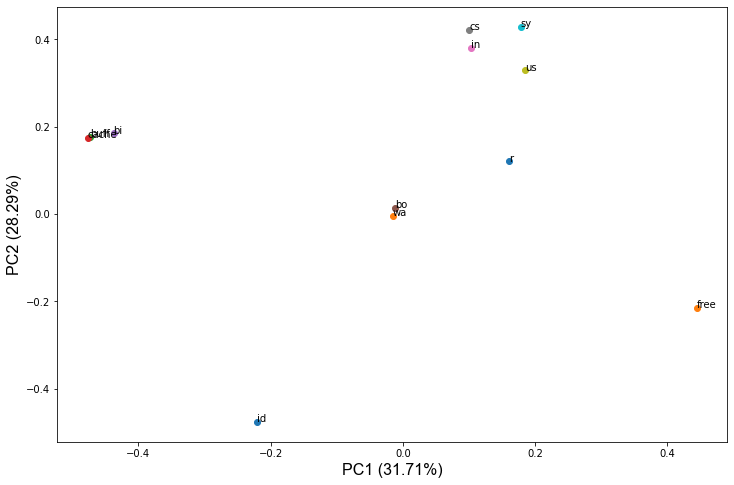

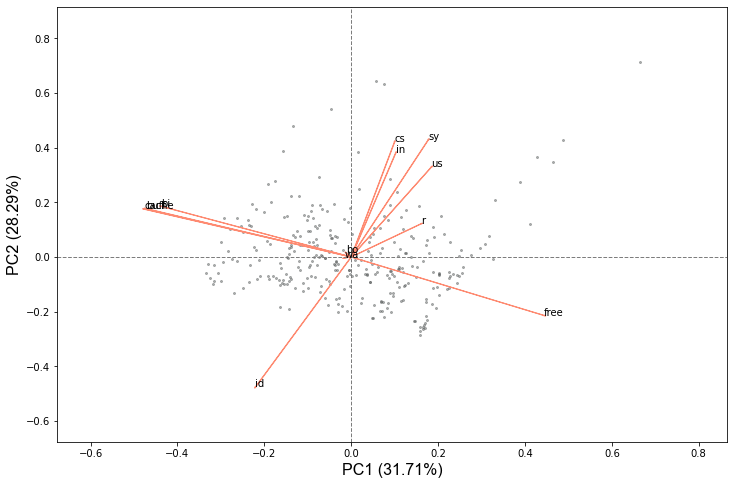

In [7]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_low.columns.values
loadings_df = loadings_df.set_index('variable')

cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df_low.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), show=True) # plotlabels= False
cluster.biplot(cscore=pca_data, loadings=loadings, labels=df_low.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), axlabelfontsize=16, dim = (12,8), valphadot = 0.4, dotsize = 4, show=True)

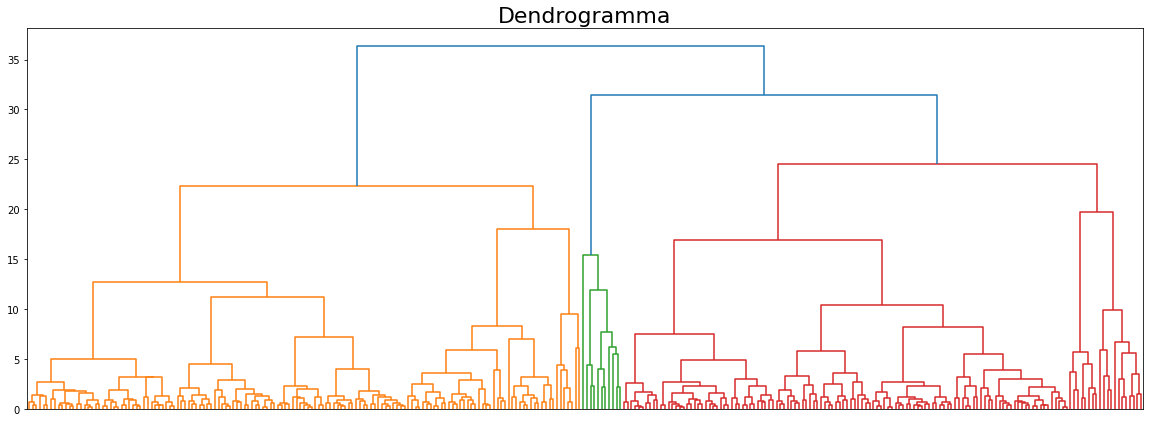

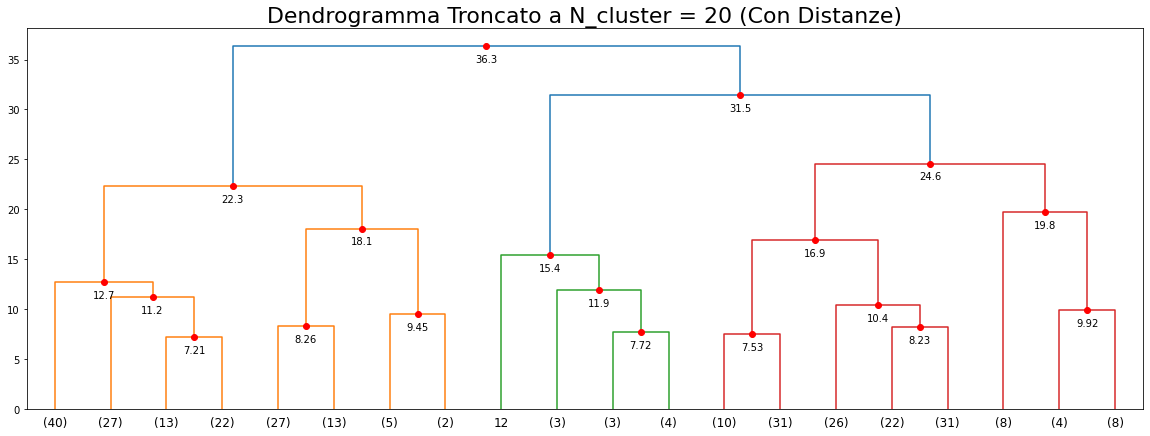

In [8]:
pca89_df = pca_df[pca_df.columns[0:6]]


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca89_df - pca89_df.mean(axis=0))**2).values.sum()
#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:6].sum()/100

linkage_matrix = sch.linkage(pca89_df, method  = "ward")

plt.figure(figsize = (20, 7))
dendrogram = sch.dendrogram(linkage_matrix, no_labels='true')
plt.title('Dendrogramma', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show()

def augmented_dendrogram(*args, **kwargs):

    ddata = sch.dendrogram(*args, **kwargs)
    distanze = []
    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            distanze.append(y)
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')
    distanze.sort(reverse=True)
    return ddata, distanze

p = 20

plt.figure(figsize = (20, 7))
_, distanze = augmented_dendrogram(linkage_matrix, p, truncate_mode='lastp')
plt.title('Dendrogramma Troncato a N_cluster = 20 (Con Distanze)', size=22)
plt.xlabel('')
plt.ylabel('')
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,p)
distance_table['Distanza'] = distanze

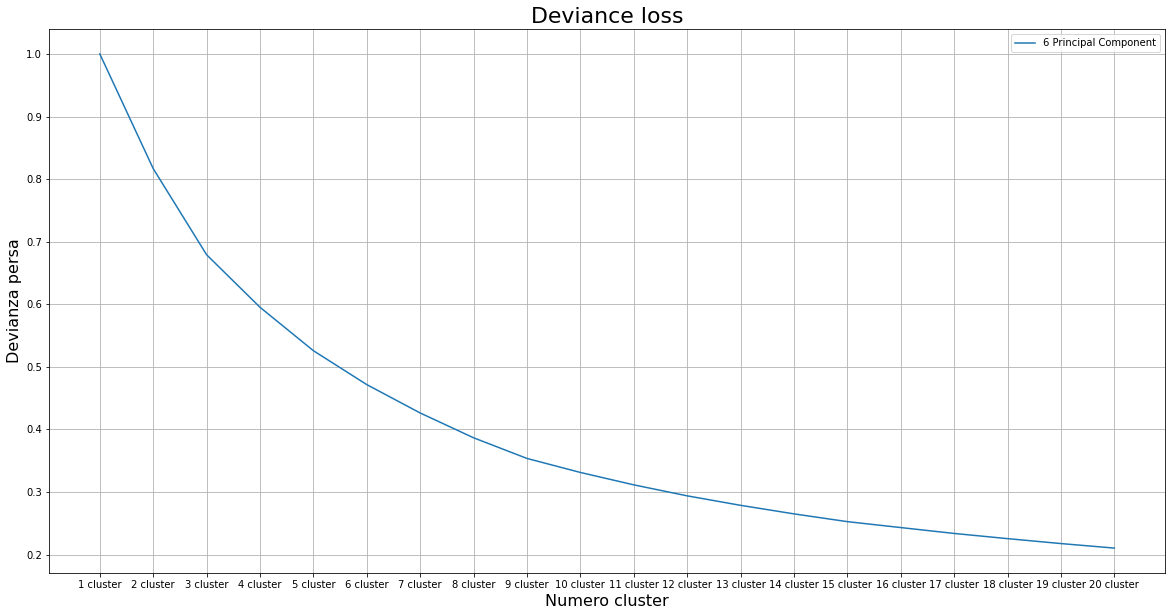

In [9]:
pca_df_dict={}

scelta_cluster_dict={}

cluster_df_dict={}

#Calcolo devianza totale del modello
dev_tot = ((scaled_df - scaled_df.mean(axis=0))**2).values.sum()

#Calcolo dimensione totale DATASET di partenza
dim_tot = scaled_df.size

k = 6 # numero pca

numero_cluster = 20;


pca_df_dict[k] = pd.DataFrame(pca_df[pca_df.columns[0:k]])


#Calcolo devianza spiegata dalla PCA 
dev_pca = ((pca_df_dict[k] - pca_df_dict[k].mean(axis=0))**2).values.sum()
#dev_pca_perc2 = dev_pca/dev_tot #più precisa
#Calcolo devianza percentuale spiegata dalla PCA
dev_pca_percentuale = per_var[0:k+1].sum()/100

linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")


cluster_df = pd.DataFrame()

scelta_cluster_dict[k] = pd.DataFrame(columns=["N cluster", "dev_loss", "dev_rimasta", "dim_ratio"])

for p in range(1,numero_cluster+1):
    array_dist = fcluster(linkage_matrix, p, criterion='maxclust')
    col_label = str(p)+" cluster"
    cluster_df[col_label]=array_dist



cluster_df_dict[k] = cluster_df

for cont,i in enumerate(cluster_df.columns, 1):
    dev_intra = 0; dev_inter = 0

    gruppi = cluster_df[i].groupby(cluster_df[i])
    for gr in range(1,max(cluster_df[i])+1):
        gruppetto = pd.DataFrame(gruppi.get_group(gr))
        gruppetto = gruppetto.join(pca_df_dict[k])
        gruppetto = gruppetto.drop(columns=[i])
        centroid = gruppetto.mean(axis = 0)
        centroid = centroid.to_numpy()
        dev_intra = dev_intra + ((gruppetto-centroid)**2).values.sum()
        dev_inter = dev_inter + len(gruppetto)*(((centroid-pca_df_dict[k].mean(axis=0))**2).values.sum())


    dev_lost_percentuale = (1 - dev_pca/dev_tot)+(dev_intra/dev_tot)
    dev_pca_cl_per = dev_inter/dev_tot
    dim_ratio =  (cont * k) / dim_tot

#         print((dev_intra + dev_inter)/dev_pca)

    new_row = {'N cluster':i, 'dev_loss':dev_lost_percentuale, 'dev_rimasta':dev_pca_cl_per, 'dim_ratio':dim_ratio}
    scelta_cluster_dict[k] = scelta_cluster_dict[k].append(new_row, ignore_index=True)


plt.figure(figsize = (20, 10))

plt.plot(scelta_cluster_dict[k]["N cluster"], scelta_cluster_dict[k]["dev_loss"], label='{} Principal Component'.format(k))
plt.legend(loc='upper right')
plt.title('Deviance loss', size=22)
plt.xlabel('Numero cluster', size=16)
plt.ylabel('Devianza persa', size=16)
plt.grid()
plt.show()

In [10]:
scelta_cluster_dict[6]

,N cluster,dev_loss,dev_rimasta,dim_ratio
0,1 cluster,1.000000,0.000000,0.001667
1,2 cluster,0.816776,0.183224,0.003333
2,3 cluster,0.679154,0.320846,0.005000
3,4 cluster,0.595218,0.404782,0.006667
4,5 cluster,0.525847,0.474153,0.008333
5,6 cluster,0.471656,0.528344,0.010000
6,7 cluster,0.426332,0.573668,0.011667
7,8 cluster,0.386692,0.613308,0.013333
8,9 cluster,0.353702,0.646298,0.015000
9,10 cluster,0.331319,0.668681,0.016667


# Direi 9 clusters

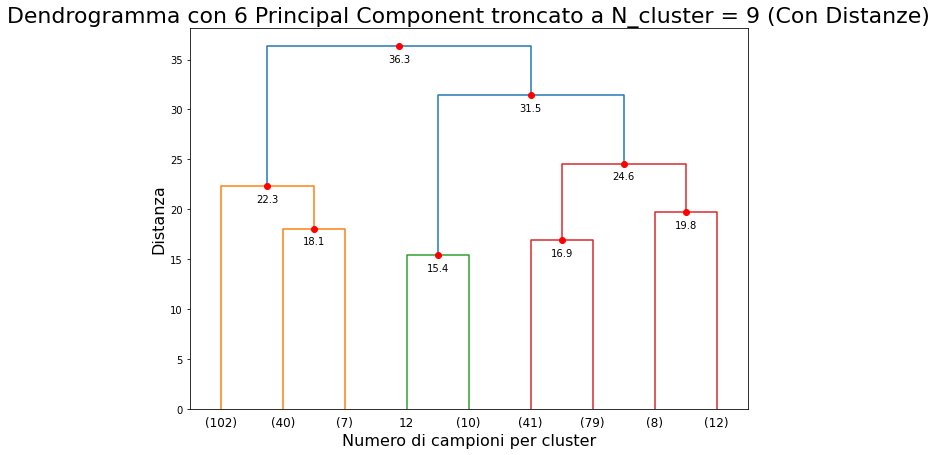

   Numero cluster   Distanza
0               1  36.320930
1               2  31.478221
2               3  24.583305
3               4  22.348967
4               5  19.752732
5               6  18.064717
6               7  16.894047
7               8  15.412008


In [11]:
linkage_matrix = sch.linkage(pca_df_dict[k], method  = "ward")
plt.figure(figsize = (10, 7))
_, distanze = augmented_dendrogram(linkage_matrix, 9, truncate_mode='lastp')
plt.title('Dendrogramma con 6 Principal Component troncato a N_cluster = 9 (Con Distanze)', size=22)
plt.xlabel('Numero di campioni per cluster', size = 16)
plt.ylabel('Distanza', size = 16)
plt.show();

distance_table= pd.DataFrame()
distance_table['Numero cluster'] = range(1,9)
distance_table['Distanza'] = distanze

print(distance_table)

In [12]:
df_low["9_cluster"] = cluster_df_dict[k]["9 cluster"]

grs = df_low.groupby("9_cluster")

# print(df_low.size_group.value_counts())

index_list = []

for g in grs:
    sample=grs.get_group(g[0]).sample(random_state=42)
    print(sample)
    index_list.append(sample.index[0])
    
# synt_workload_low = df_low[df_low.index.isin(index_list)]
# synt_workload_low

synt_workload_low = pca_df_dict[k][pca_df_dict[k].index.isin(index_list)]
synt_workload_low

    r    free   buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
45  0  116464  30224  631012   0   4  606  447   5   8  87   0          1
    r    free   buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
97  0  113376  30308  631128   4  56  812  511   3  15  82   0          2
   r    free   buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
8  5  117156  30176  630976   0   4  177  531  15   7  78   0          3
     r    free   buff   cache  bi  bo    in   cs  us  sy  id  wa  9_cluster
280  0  105736  30588  631548  20   4  1319  612   7  22  70   0          4
     r    free   buff   cache  bi  bo   in    cs  us  sy  id  wa  9_cluster
12  10  115412  30188  630948   0   4  692  1012  47  16  37   0          5
     r    free   buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
243  0  109368  30520  631356  16   4  331  380   4   6  90   0          6
     r    free   buff   cache  bi  bo   in   cs  us  sy  id  wa  9_cluster
217  3  109368  30464  631316

,PC1,PC2,PC3,PC4,PC5,PC6
8,3.842677,-0.094812,3.895122,1.011912,-0.114757,1.320620
12,7.858037,8.771275,9.060367,3.036811,-0.273418,0.786833
45,2.225987,-1.393447,-0.457763,-0.534012,0.144484,-0.254335
90,1.061289,-0.637732,-2.027771,2.310120,-3.168542,0.341437
97,1.340678,0.348752,-1.424372,-0.526598,-0.213823,0.260085
217,-0.935396,0.540011,1.095654,-0.245973,0.089047,2.214816
243,-2.114207,-0.840469,0.402115,-0.354523,0.136106,0.195338
278,-2.708065,2.372603,-1.329082,3.372981,2.489667,0.400539
280,-1.842393,4.758482,-1.533173,-1.165567,0.329982,0.596026


In [13]:
synt_workload_low.to_csv("synt_wl_low_pre.csv", index_label='id')